## Swipr with Resnext

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This is so that any time a long-running process completes we can ping the browser with a sound.
from IPython.display import Audio
sound_file = './sound/beep.wav'
# at the end of any cell where sound is desired, place the following for a ping:
# Audio(url=sound_file, autoplay=True)

In [14]:
import sqlite3, os, sys, csv
from pathlib import Path
import pdb

In [ ]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Setup

In [4]:
PATH = Path("./data/swipr/")
assert PATH.exists(), "data directory does not exist"

# on-the-fly yes/no label generation

Using our `sortdb.sqlite` file, we'll construct a `labels.csv` on the fly by checking off which of our assorted paths we want to mark as being `YES` or `NO`.

In [5]:
dbloc = PATH/'sortdb.sqlite'
assert dbloc.exists(), "db file didn't exist"

In [6]:
WITH_BABY = "with_baby"
TOO_YOUNG = "too_young"
TOO_OLD = "too_old"
PURIKURA = "purikura"
GENERAL_NO = "general_no"
OK = "OK"
TINDER_DUDES = "tinder_dudes"
TINDER_GIRLS = "tinder_girls"

MainDirs = {
    WITH_BABY: "insta/with_baby/", 
    TOO_YOUNG: "insta/too_young/", 
    TOO_OLD: "insta/too_old/", 
    PURIKURA: "insta/purikura/",
    GENERAL_NO: "insta/no/",
    OK: "insta/ok/",
    TINDER_DUDES: "tinder/dudes",
    TINDER_GIRLS: "tinder/girls",
}

We create the first pass at things that will be yes or no.   
In our case, everything in `NoLabels` is unconditionally no, while things in the `YesLabels` category will be subject to additional constraints

In [7]:
YesLabels = [OK]
NoLabels = [TINDER_DUDES, TINDER_GIRLS, WITH_BABY, TOO_YOUNG, TOO_OLD, PURIKURA, GENERAL_NO]

For the `YesLabels`, we pull each picture and ask of it a series of questions. Failing any one of these questions will result in that picture being marked as 'no':

1. Is there a male present?
1. Are there more than X many people?
1. Is there at least one girl in the picture?

We had an age requirement, but it proved to be too unreliable to use correctly. 20+ year old girls were being classified as anywhere between 6 and 32 years old depending on the rotation of their face during pre-scan time.  

Since all our data is based on pre-vetted profiles, we can be sure that, aside from some potential outliers, all profiles scraped were girls of legal age in both Japan and the United States.

In [8]:
FAIL_ON_MALE = True # We set this to true because we aren't interested in the nn learning to say yes to men.
MAX_PEOPLE = 1 # if set to zero, there is no upper limit on people in the picture. 
MIN_PEOPLE = 1 # We set this to 1 because we want the NN to reject pictures of food, beaches, etc
MIN_AGE = 0 # if set to zero, there is no lower limit on the age of people in the picture. See above as to why.
MAX_AGE = 0 # if set to zero, there is no upper limit on the age of people in the picture. 

In [9]:
FAIL_AGE_INT = -3
FAIL_MALE_INT = -4
FAIL_NOFACE_INT = -5
FAIL_INVALID_INT = -6
FAIL_GROUP = -7
FAIL_ROTATEDNOCHANGED_INT=-8
FAIL_BASE_INT = 0

Now we can query our database and sort things into categories

In [10]:
def GetSql(db=dbloc):
    conn = sqlite3.connect(str(db.resolve()))
    cursor = conn.cursor()
    return conn, cursor

In [11]:
def _Filter(row, verbose=False):
    # Get the path of our consideration
    p = row[0]
    
    # Check that path isn't in our unconditional 'no' set
    for nopath in [MainDirs[x] for x in NoLabels]:
        if p.startswith(nopath):
            return False

    # Check that the label doesn't immediately disqualify from consideration
    label = row[1]
    if label in [FAIL_NOFACE_INT, FAIL_ROTATEDNOCHANGED_INT]:
        return False
    
    # check number of people
    num_people = row[3]
    if MAX_PEOPLE > 0 and num_people > MAX_PEOPLE:
        return False
    
    # Check that there are no males
    male_present = row[4]
    if FAIL_ON_MALE and male_present:
        return False

    # Check ages
    age_str = row[2].split(',')
    ages = []
    for x in age_str:
        try:
            a = int(x)
            ages.append(a)
        except:
            continue
    if MIN_AGE > 0:
        min_passed = all([x >= MIN_AGE for x in ages])
        if not min_passed:
            return False
    if MAX_AGE > 0:     
        max_passed = all([x <= MAX_AGE for x in ages])
        if not max_passed:
            return False
        
    return True

In [12]:
def Filter():
    conn, cursor = GetSql()
    q = "SELECT path, label, ages, num_people, male_present FROM pics WHERE label NOT IN (?);"
    yeses = []
    nos = []
    for row in cursor.execute(q, (FAIL_INVALID_INT, )):
        p = row[0]
        if _Filter(row):
            yeses.append(p)
        else:
            nos.append(p)
    return yeses, nos

The only thing we've excluded outright are images that were straight up invalid, as in, could not be parsed by our pre-screener for some reason or another. This error is denoted by the constant `FAIL_INVALID_INT`, or `-6`

In [13]:
y,n = Filter()

In [14]:
print("len(nos): {0}".format(len(n)))
print("len(yeses): {0}".format(len(y)))

len(nos): 201573
len(yeses): 47777


In [15]:
def MakeCSV(cname, yeses, nos):
    with open(PATH/cname, 'w', newline='', encoding="utf8") as csvfile:
        
        resolved = PATH.resolve()
        
        # get a csv writer with some defaults
        cwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        
        # Write the header
        cwriter.writerow(["path", "label"])
        
        # write the nos
        for p in nos:
            cwriter.writerow([os.path.join(resolved, p), "NO"])
            
        # write the yesses
        for p in yeses:
            cwriter.writerow([os.path.join(resolved, p), "YES"])
            
    return PATH/cname

In [18]:
#label_csv = MakeCSV("test1.csv", y, n)
label_csv = PATH/'test1.csv'

In [19]:
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [24]:
#torch.save(val_idxs, PATH/'val_idxs.pkl',)

In [25]:
val_idxs = torch.load(PATH/'val_idxs.pkl')

In [ ]:
label_df = pd.read_csv(label_csv)
label_df.head()

In [29]:
sz=224
arch=resnext50
bs=24
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [20]:
data = ImageClassifierData.from_csv(PATH, PATH, label_csv, val_idxs=val_idxs, tfms=tfms, bs=bs)

In [21]:
len(data.trn_ds), len(data.val_ds)

(203966, 50991)

In [22]:
len(data.classes), data.classes

(2, ['NO', 'YES'])

In [42]:
fidx = random.randint(0, len(data.trn_ds))
fn = data.trn_ds.fnames[fidx]
ys = data.trn_ds.y[fidx]

/home/paperspace/data/swipr/insta/OK/chisato1310mc/1836680554462636415.jpg
0


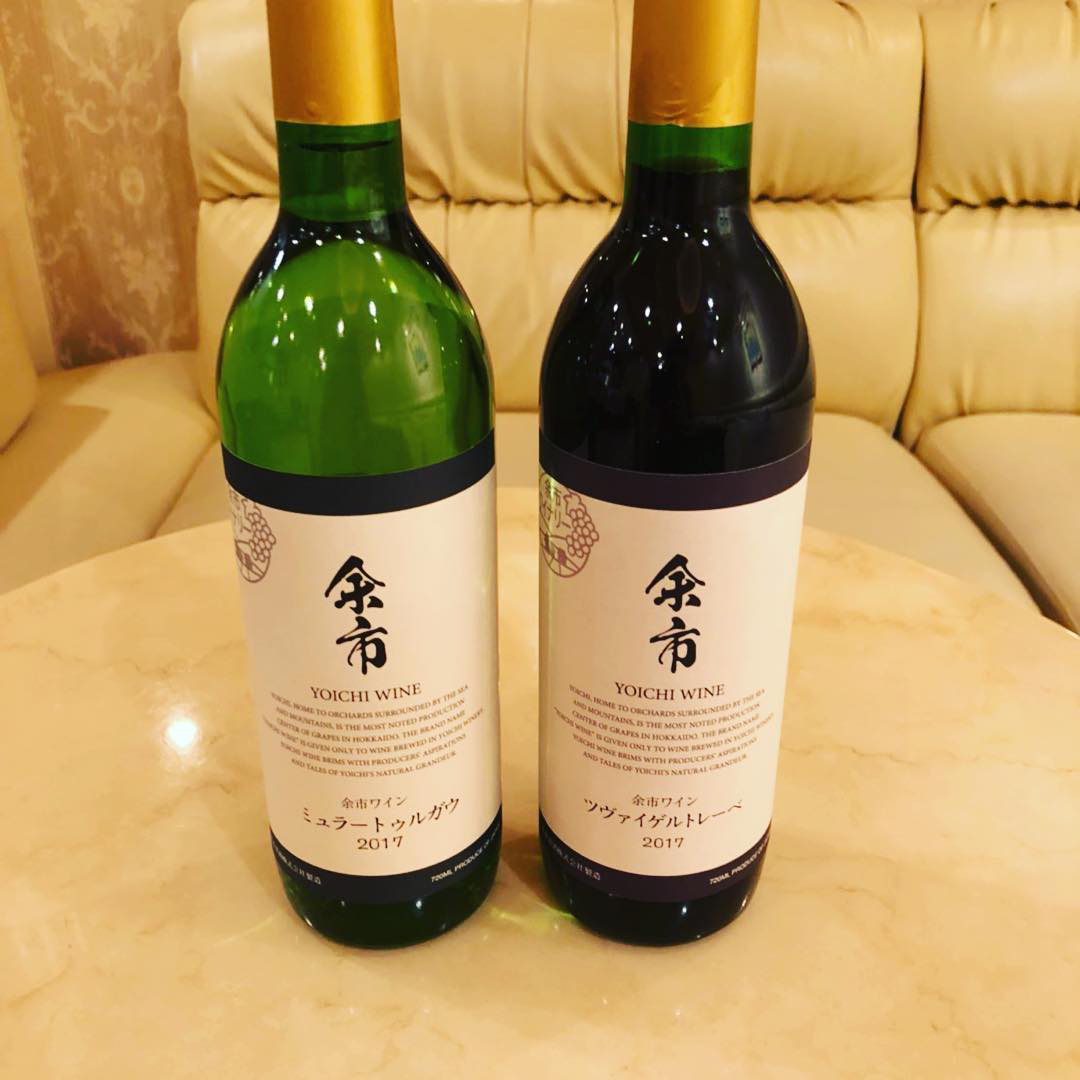

In [43]:
print(fn)
print(ys)
img = PIL.Image.open(fn)
img

In [144]:
img.size

(1080, 1350)

In [169]:
size_d = {k: PIL.Image.open(k).size for k in data.trn_ds.fnames}

row_size, col_size = list(zip(*size_d.values()))

row_size = np.array(row_size)
col_size = np.array(col_size)

row_size[:5]

array([1080, 1080, 1080, 1080, 1080])

(array([  1868.,  30387., 171645.,     18.,     24.,     14.,      1.,      6.,      1.,      2.]),
 array([ 186. ,  490.8,  795.6, 1100.4, 1405.2, 1710. , 2014.8, 2319.6, 2624.4, 2929.2, 3234. ]),
 <a list of 10 Patch objects>)

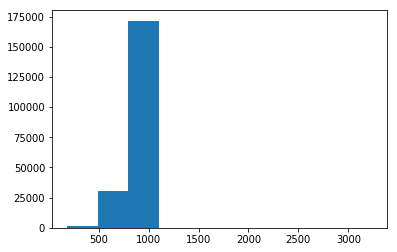

In [170]:
plt.hist(row_size)

(array([  2593.,  36665., 108342.,  56317.,     25.,     14.,      1.,      6.,      1.,      2.]),
 array([ 167. ,  473.7,  780.4, 1087.1, 1393.8, 1700.5, 2007.2, 2313.9, 2620.6, 2927.3, 3234. ]),
 <a list of 10 Patch objects>)

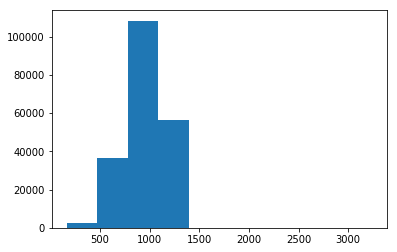

In [171]:
plt.hist(col_size)

(array([   22.,   372.,   630.,  1219.,  1487., 18487.,  8878.,  3331.,  4014.,  5948.]),
 array([186. , 267.3, 348.6, 429.9, 511.2, 592.5, 673.8, 755.1, 836.4, 917.7, 999. ]),
 <a list of 10 Patch objects>)

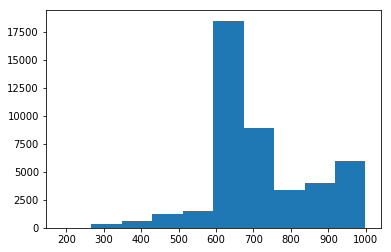

In [172]:
plt.hist(row_size[row_size < 1000])

(array([  209.,   480.,   996.,  1540.,  2249., 19933.,  9097., 18299.,  5149.,  5400.]),
 array([167. , 250.2, 333.4, 416.6, 499.8, 583. , 666.2, 749.4, 832.6, 915.8, 999. ]),
 <a list of 10 Patch objects>)

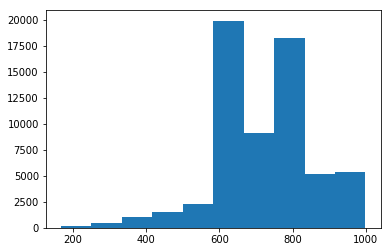

In [173]:
plt.hist(col_size[col_size < 1000])

In [27]:
def get_data(size, batchSize):
    tfms = tfms_from_model(arch, size, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, PATH, label_csv, val_idxs=val_idxs, tfms=tfms, bs=bs)
    #data = ImageClassifierData.from_csv(PATH, , label_csv, num_workers=4, val_idxs=val_idxs, suffix=".jpg", tfms=tfms, bs=batchSize)
    return data if size > 300 else data.resize(340, "tmp")

# Pre Compute

In [30]:
data = get_data(sz, bs)

In [31]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [35]:
learn.fit(1e-4, 1)

epoch      trn_loss   val_loss   accuracy                        
    0      0.405539   0.397465   0.817967  


[array([0.39746]), 0.8179667116376808]

In [38]:
# this is the first of a new training batch
# it used learn.fit(1e-4, 1)
# it achieved the following stats:
# trn_loss    val_loss    accuracy
#   0.405        0.397      0.817
s0 = "swipr1_1e4_1_397"
learn.save(s0)

In [39]:
learn.load(s0)

In [41]:
# this is the continuation of the previous batch, which uses the same
# 1e-4, but with 3 additional epochs and cycle_len1 and cycle_mult2
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                        
    0      0.399513   0.392782   0.819912  
    1      0.403108   0.390016   0.822238                        
    2      0.393089   0.39024    0.822318                        
    3      0.388752   0.38785    0.824343                        
    4      0.399516   0.384942   0.825968                        
 10%|█         | 857/8312 [03:41<28:39,  4.33it/s, loss=0.392]  

KeyboardInterrupt: 

In [43]:
s1 = "swipr1_1e4_3__1_2_082"

In [44]:
# this is the continuation of swipr1_1e4_1_397
# it used learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2),
# but was killed after 5 epochs because it wasn going nowhere
# it achieved the following stats:
# trn_loss    val_loss    accuracy
# 0.399516    0.384942    0.825968

learn.save(s1)

In [45]:
learn.load(s1)

In [32]:
learn.lr_find()

 74%|███████▍  | 6171/8312 [26:13<09:41,  3.68it/s, loss=1.58]   

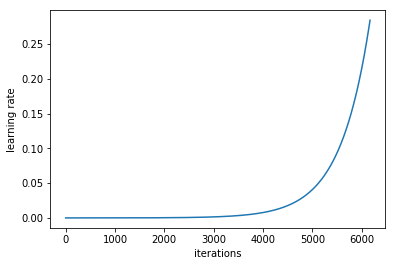

In [33]:
learn.sched.plot_lr()

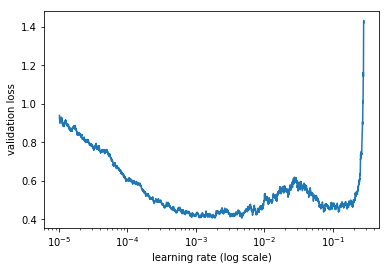

In [34]:
learn.sched.plot()

# Increase Size

In [46]:
learn.set_data(get_data(229,bs))
learn.freeze()

In [47]:
learn.fit(1e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                        
    0      0.382748   0.378121   0.828554  
    1      0.380391   0.371811   0.83062                         
    2      0.378256   0.370223   0.831061                        


[array([0.37022]), 0.8310607560566105]

In [48]:
s3 = "swipr1_1e3_3_1_1_370"

In [49]:
# This is the continuation of S1, which was killed after 5 epohcs
# It used learn.fit(1e-3, 3, cycle_len=1) 
# We have adjusted the LR upwards a bit.
# It achieved the following stats:

#learn.save(s3)

In [51]:
learn.load(s3)

In [ ]:
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                        
    0      0.372923   0.365708   0.832845  
    1      0.359612   0.364647   0.832565                        
    2      0.382324   0.368091   0.832244                        
 23%|██▎       | 1890/8312 [08:57<34:27,  3.11it/s, loss=0.391]  

In [34]:
log_preds, y = learn.TTA()
#probs = np.exp(log_preds)
probs = np.mean(np.exp(log_preds),0)

In [43]:
z = np.exp(log_preds)
metrics.log_loss(y, probs)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [44]:
learn.save('breeds_299_pre')
learn.load('breeds_299_pre')

In [ ]:
learn.fit(1e-2, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.277227   0.299337   0.906556  
 52%|█████▏    | 178/341 [00:23<00:21,  7.43it/s, loss=0.233]

In [ ]:

learn.save('breeds_299_pre')

# Old Stuff

In [5]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)

In [6]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [53]:
learn.fit(1e-2, 1)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy                        
    0      0.370794   0.361677   0.83086   


In [54]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                        
    0      0.366622   0.357719   0.835613  
    1      0.390506   0.3543     0.836074                        


[array([0.3543]), 0.836073789751097]

In [55]:
learn.save("swipr1_3")

In [56]:
learn.load("swipr1_3")

In [48]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [49]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.600669   0.448956   0.866438  
    1      0.479166   0.459715   0.863992                    
    2      0.432332   0.454395   0.865949                    


[array([0.45439]), 0.8659491170409142]

In [50]:
learn.save('224_all_50')

In [51]:
learn.load('224_all_50')

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

 25%|██▌       | 1/4 [00:11<00:33, 11.06s/it]

In [16]:
accuracy_np(probs,y)

0.9965

## Analyzing results

In [17]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[996   4]
 [  3 997]]


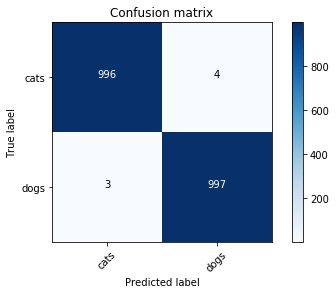

In [18]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


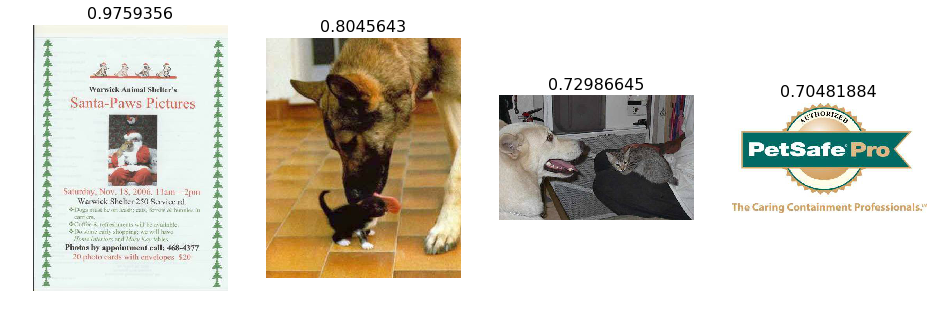

In [20]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


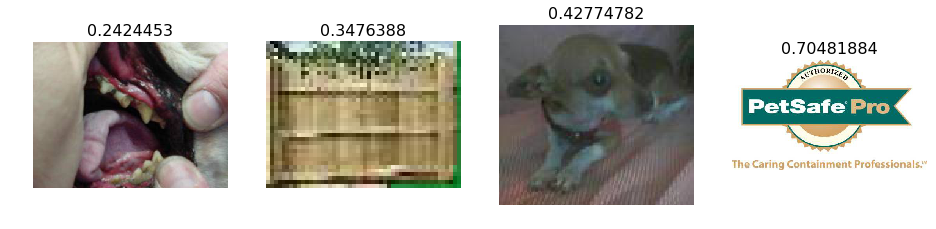

In [21]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")